# Introduction
This notebook uses survey data collected from Dec 2022 to Mar 2023 on smartphone wellbeing feature awareness and usage. The CSV file used in this analysis has been deidentified and manipulated in Excel before being brough into Jupyter Notebooks.

# Data Setup

In [2]:
# import packages for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [3]:
# import data
df = pd.read_csv('wellbeing_survey_responses.csv')
df.dropna(subset=['age'],inplace=True) #there is one row with all blanks including the age

## Data Encoding

In [4]:

# convert timestamp column from object to datetime data type
df['response_timestamp'] = pd.to_datetime(df['response_timestamp'])

# encode the ordinal age column to labels
age_ordinal_values = { 'Prefer not to answer': -1, '18 to 24 years': 1, '25 to 34 years': 2
                      , '35 to 44 years': 3, '45 to 54 years': 4, '55 to 64 years': 5,
                     '65+ years': 6}

df['age_encoded'] = df['age'].map(age_ordinal_values)

# encode the categorical feature learning column to one-hot encoding
flm_one_hot_df = pd.get_dummies(data=df['feature_learn_method'], prefix='flm', dummy_na=True)

df = pd.concat([df, flm_one_hot_df], axis=1)

# encode the categorical phone type column to iPhone flag, question was required in survey so data cannot be blank
def phone_type_mapping_func(ptype : str):
    if ptype == 'Prefer not to answer':
        return -1
    elif ptype == 'Apple iPhone':
        return 1
    else:
        return 0
    
df['iphone_flag'] = df['phone_type'].apply(phone_type_mapping_func)

In [5]:
# coalesce the awareness and usage columns to one column for analysis
# source: https://www.statology.org/pandas-coalesce/
df['all_phone_feature_aware'] = df[['iphone_aware', 'samsung_aware', 'pixel_aware', 'other_aware']].bfill(axis=1).iloc[:, 0]
df['all_phone_feature_usage'] = df[['iphone_usage', 'samsung_usage', 'pixel_usage', 'other_usage']].bfill(axis=1).iloc[:, 0]

## Calculate ACTA Score

In [14]:

# Calculate the autonomous regulation score by getting the average score for questions that are
# intrinsic and identified motivated
intrinsic_identified_columns_list = ['expected_interesting_intrinsic', 'belief_life_improvement_identified'
                                     ,'help_do_important_identified', 'expect_enjoyable_intrinsic'
                                     , 'be_of_value_life_identified', 'fun_to_use_intrinsic']


df['autonomous_regulation_score'] = df[intrinsic_identified_columns_list].mean(axis=1)

In [13]:
# Calculate the controlled regulation score by getting the average score for questions that are
# external and introjected motivated
external_introjected_columns_list = ['others_want_me_use_external', 'others_know_usage_introjected'
                                     ,'feel_bad_not_trying_introjected', 'required_usage_external'
                                     , 'pressure_usage_external', 'look_good_others_introjected']


df['controlled_regulation_score'] = df[external_introjected_columns_list].mean(axis=1)

In [15]:
# Calculate relative autonomy index (RAI) by subtracting the average for Controlled Regulation
# from the average for Autonomous Regulation
df['relative_autonomy_index'] = df['autonomous_regulation_score'] - df['controlled_regulation_score']

In [31]:
# Return the ACTA Score for people who used wellbeing features
df.loc[df['usage_flag'] == 1, ['autonomous_regulation_score', 'controlled_regulation_score', 'relative_autonomy_index' ]]

,autonomous_regulation_score,controlled_regulation_score,relative_autonomy_index
1,3.000000,1.000000,2.000000
3,2.666667,1.000000,1.666667
5,1.333333,1.000000,0.333333
7,1.333333,1.000000,0.333333
8,2.333333,1.000000,1.333333
...,...,...,...
349,4.166667,1.833333,2.333333
350,1.500000,1.166667,0.333333
351,3.333333,2.166667,1.166667
352,2.833333,2.333333,0.500000


In [16]:
df.columns

Index(['ID', 'response_timestamp', 'age', 'feature_learn_method',
       'autonomy_avgscore', 'relatedness_avgscore', 'competence_avgscore',
       'pressured_to_use_more', 'spend_more_time_than_should',
       'makes_me_do_unwanted_things', 'life_intrusive',
       'more_ability_insecurity', 'less_capable', 'lowered_confidence',
       'belonging_to_community', 'close_connect_important_persons',
       'close_to_some', 'phone_type', 'awareness_flag', 'awareness_count',
       'usage_flag', 'usage_count', 'others_want_me_use_external',
       'expected_interesting_intrinsic', 'belief_life_improvement_identified',
       'help_do_important_identified', 'others_know_usage_introjected',
       'feel_bad_not_trying_introjected', 'expect_enjoyable_intrinsic',
       'required_usage_external', 'be_of_value_life_identified',
       'fun_to_use_intrinsic', 'pressure_usage_external',
       'look_good_others_introjected', 'iphone_aware', 'iphone_usage',
       'pixel_aware', 'pixel_usage', 'oth

# Descriptive Statistics

## How many surveyed participants in each age group?

In [70]:
print(df['age'].value_counts(), '\n')
print(df['age'].value_counts(normalize=True))

25 to 34 years          117
18 to 24 years           74
35 to 44 years           49
65+ years                45
45 to 54 years           33
55 to 64 years           31
Prefer not to answer      4
Name: age, dtype: int64 

25 to 34 years          0.331445
18 to 24 years          0.209632
35 to 44 years          0.138810
65+ years               0.127479
45 to 54 years          0.093484
55 to 64 years          0.087819
Prefer not to answer    0.011331
Name: age, dtype: float64


In [69]:
print(df['feature_learn_method'].value_counts(),'\n')
print(df['feature_learn_method'].value_counts(normalize=True))

OrganicUsage         154
AnotherPerson        114
Proactive             43
SearchAfterUpdate     39
CompanyEmail           2
Name: feature_learn_method, dtype: int64 

OrganicUsage         0.437500
AnotherPerson        0.323864
Proactive            0.122159
SearchAfterUpdate    0.110795
CompanyEmail         0.005682
Name: feature_learn_method, dtype: float64


In [1]:
chart = sns.displot(data=df, x='age')
chart.set_xticklabels(rotation=45, ha='right')
plt.show()

NameError: name 'sns' is not defined

In [54]:
age_order_list = ['18 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years'
, '55 to 64 years', '65+ years', 'Prefer not to answer']

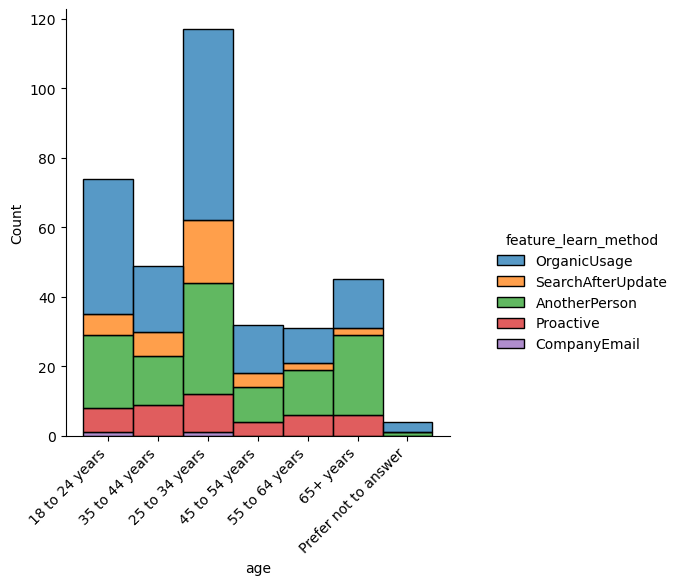

In [59]:
# stacked 100% bar chart
# chi-square test
# maybe combining the the FLM to passive vs active
chart = sns.displot(data=df, x='age', hue='feature_learn_method', multiple='stack')
chart.set_xticklabels(rotation=45, ha='right')
plt.show()

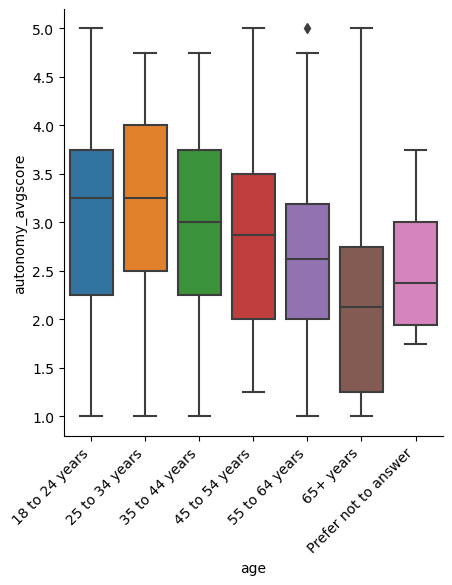

In [49]:
automony_age_boxplot = sns.catplot(data=df, x='age', y='autonomy_avgscore', kind='box', order=age_order_list)
automony_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

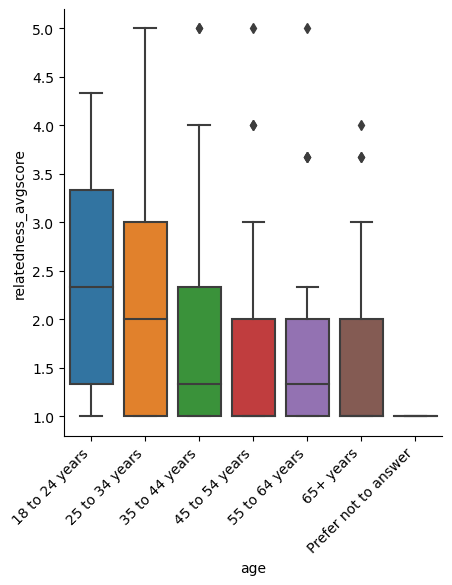

In [50]:
relatedness_age_boxplot = sns.catplot(data=df, x='age', y='relatedness_avgscore', kind='box', order=age_order_list)
relatedness_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

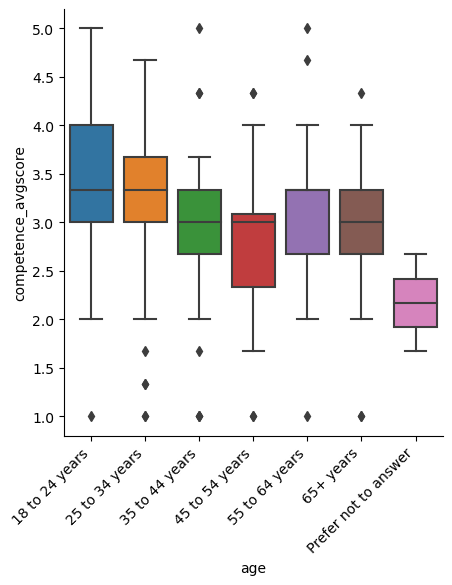

In [60]:
competence_age_boxplot = sns.catplot(data=df, x='age', y='competence_avgscore', kind='box', order=age_order_list)
competence_age_boxplot.set_xticklabels(rotation=45, ha='right')
plt.show()

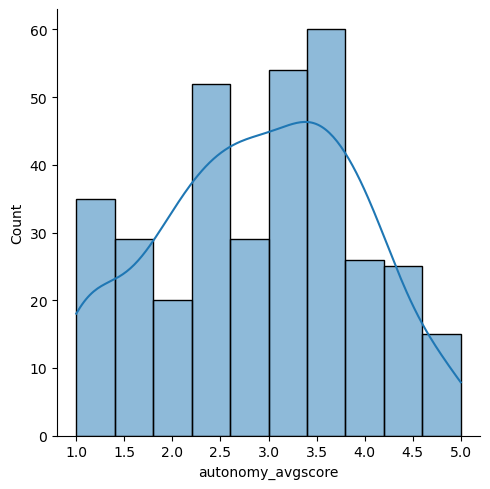

In [65]:
sns.displot(data=df, x='autonomy_avgscore', kde=True)

In [ ]:
sns.displot(data=df, x='autonomy_avgscore', kde=True)

# Hypotheses

## Hypothesis 1
Does age and feature learning method have a relationship?